# Exercises

In [1]:
# imports
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/z7mMiznEWOT0Iak')

## Exercise 1 - simulating place cells
---

Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 

In [3]:
# Linear track
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

# Mouse trajectories

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


In [4]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [5]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

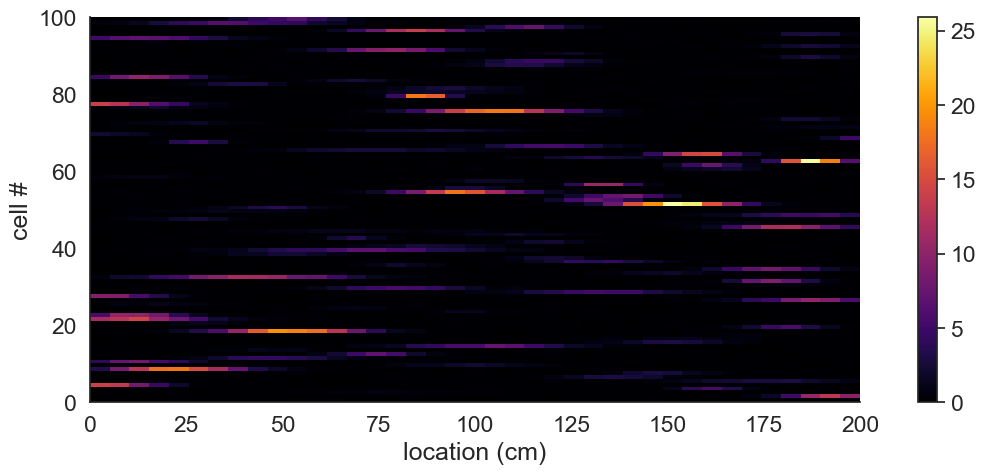

In [6]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

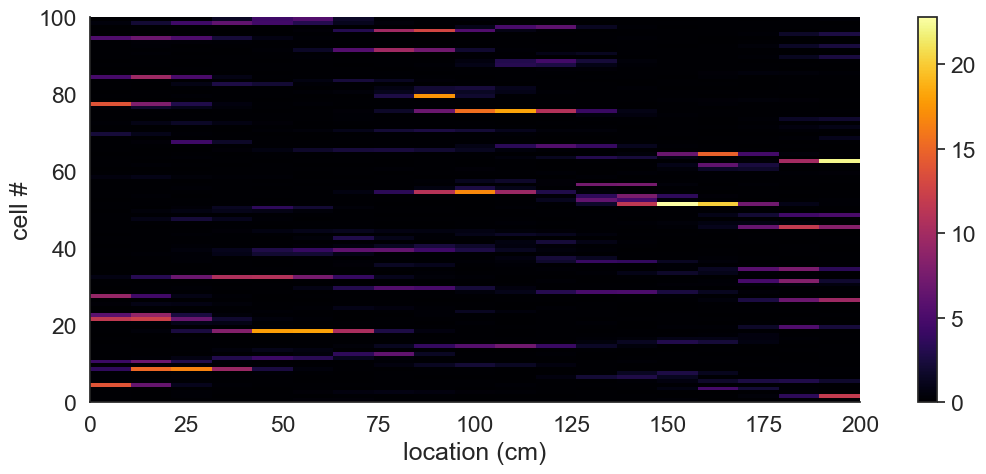

In [7]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 10.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

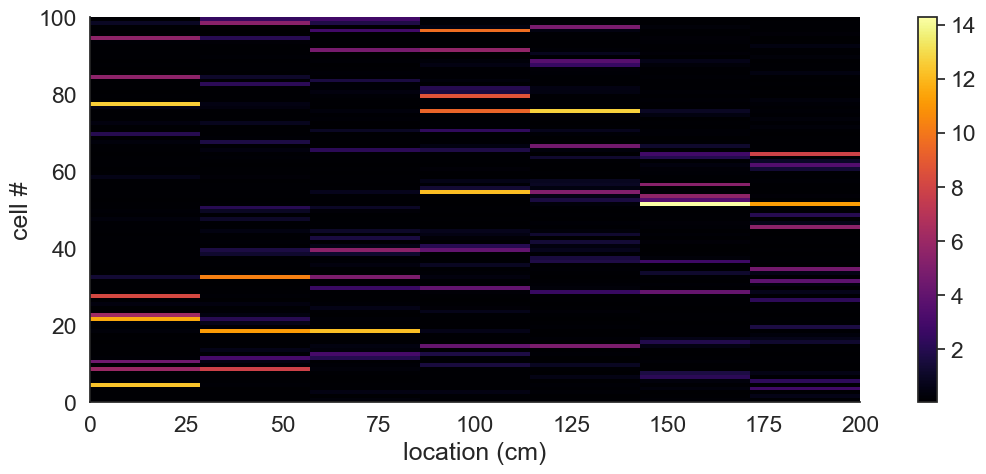

In [8]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 25.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

By making the bins broader it becomes harder to see where a neuron has exactly fired. 

B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.

In [9]:
# The noise_firing_rate variable determines the noise level


# Linear track
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

# Mouse trajectories

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)



100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


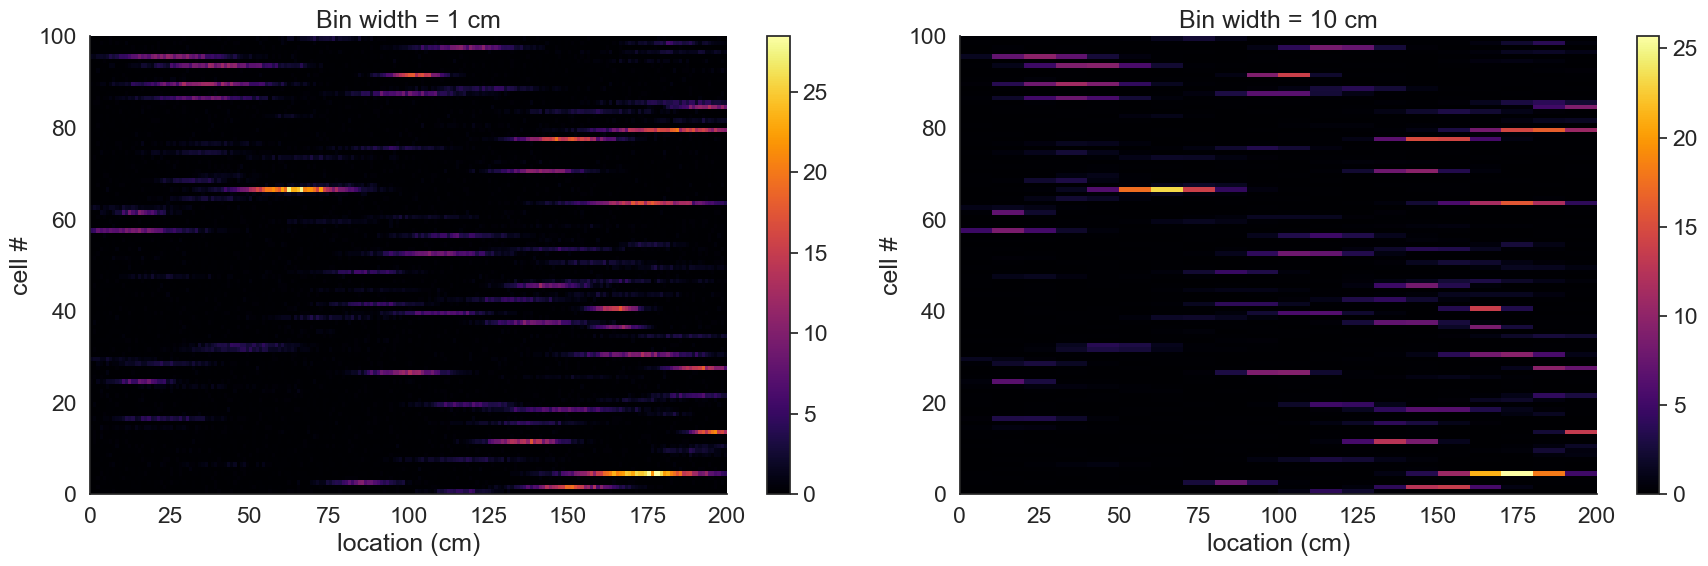

In [10]:
# Two bin widths to compare
bin_widths = [1, 10]
firing_rate_maps_list = []

for bin_width in bin_widths:
    space_bins = np.arange(0., 200. + bin_width, bin_width)
    
    # Map spike times to positions
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    # Histogram per cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # Occupancy
    occupancy = np.histogram(x, space_bins)[0] / fps
    
    # Normalize to get firing rate maps
    with np.errstate(divide='ignore', invalid='ignore'):
        firing_rate_maps = spikes_hist / occupancy
        firing_rate_maps[:, occupancy == 0] = 0

    firing_rate_maps_list.append((firing_rate_maps, bin_width))

# Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for ax, (firing_rate_maps, bin_width) in zip(axs, firing_rate_maps_list):
    extent = [0, 200, 0, n_cells]
    im = ax.imshow(firing_rate_maps, cmap='inferno', extent=extent, aspect='auto')
    ax.set_title(f'Bin width = {bin_width} cm')
    ax.set_xlabel('location (cm)')
    ax.set_ylabel('cell #')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


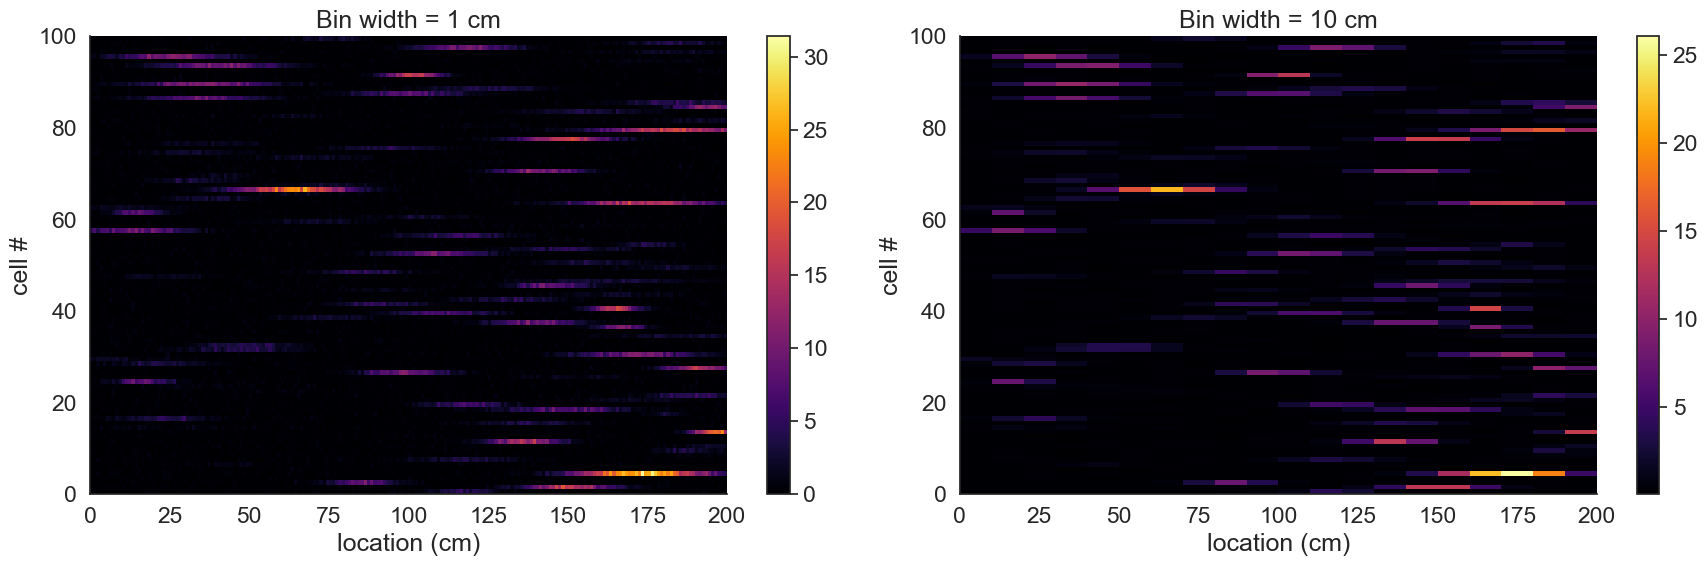

In [11]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.2 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


bin_widths = [1, 10]
firing_rate_maps_list = []

for bin_width in bin_widths:
    space_bins = np.arange(0., 200. + bin_width, bin_width)
    
    # Map spike times to positions
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    # Histogram per cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # Occupancy
    occupancy = np.histogram(x, space_bins)[0] / fps
    
    # Normalize to get firing rate maps
    with np.errstate(divide='ignore', invalid='ignore'):
        firing_rate_maps = spikes_hist / occupancy
        firing_rate_maps[:, occupancy == 0] = 0

    firing_rate_maps_list.append((firing_rate_maps, bin_width))

# Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for ax, (firing_rate_maps, bin_width) in zip(axs, firing_rate_maps_list):
    extent = [0, 200, 0, n_cells]
    im = ax.imshow(firing_rate_maps, cmap='inferno', extent=extent, aspect='auto')
    ax.set_title(f'Bin width = {bin_width} cm')
    ax.set_xlabel('location (cm)')
    ax.set_ylabel('cell #')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


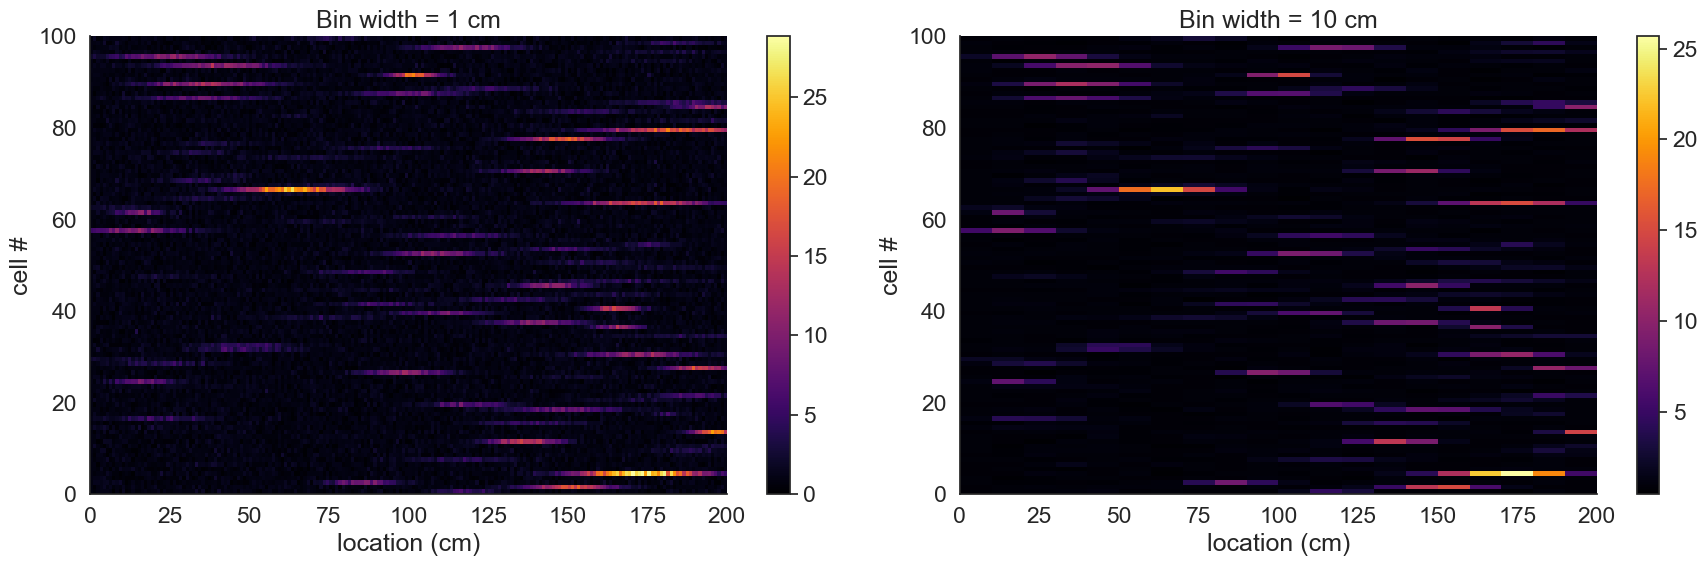

In [12]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.9 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


bin_widths = [1, 10]
firing_rate_maps_list = []

for bin_width in bin_widths:
    space_bins = np.arange(0., 200. + bin_width, bin_width)
    
    # Map spike times to positions
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    # Histogram per cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # Occupancy
    occupancy = np.histogram(x, space_bins)[0] / fps
    
    # Normalize to get firing rate maps
    with np.errstate(divide='ignore', invalid='ignore'):
        firing_rate_maps = spikes_hist / occupancy
        firing_rate_maps[:, occupancy == 0] = 0

    firing_rate_maps_list.append((firing_rate_maps, bin_width))

# Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for ax, (firing_rate_maps, bin_width) in zip(axs, firing_rate_maps_list):
    extent = [0, 200, 0, n_cells]
    im = ax.imshow(firing_rate_maps, cmap='inferno', extent=extent, aspect='auto')
    ax.set_title(f'Bin width = {bin_width} cm')
    ax.set_xlabel('location (cm)')
    ax.set_ylabel('cell #')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

When noise is high it seems to beneficial to have smaller bins.

C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


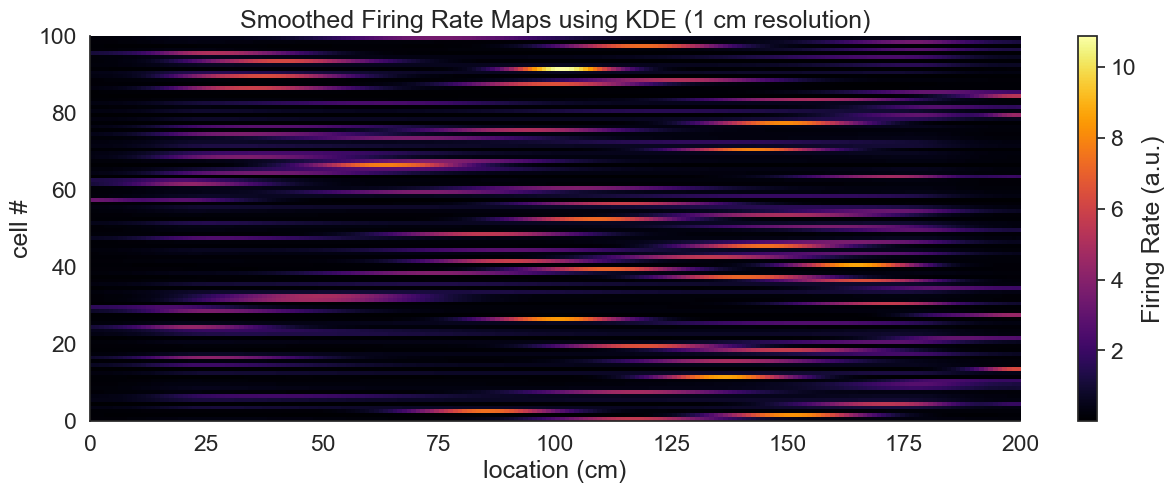

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


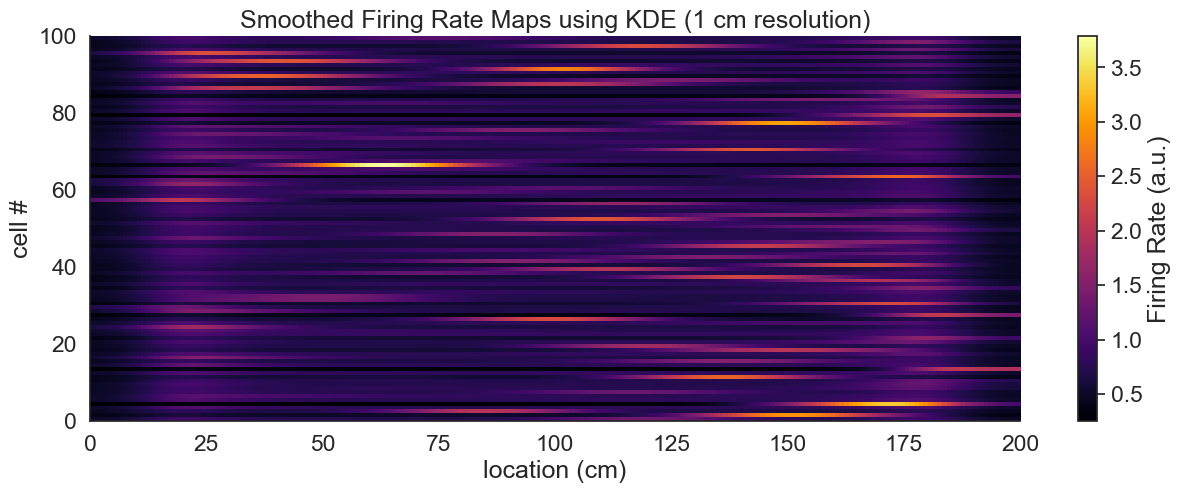

In [13]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

# Fine spatial bins (1 cm resolution)
fine_bins = np.linspace(0, 200, 201)
bin_centers = (fine_bins[:-1] + fine_bins[1:]) / 2

# Interpolate spike times to positions
spike_positions = [np.interp(s, t, x) for s in spikes]

# Estimate occupancy using Gaussian KDE
occupancy_kde = gaussian_kde(x.reshape(1, -1))
occupancy_est = occupancy_kde(bin_centers)
occupancy_est /= np.sum(occupancy_est)  # Normalize

# Smoothed firing rate maps using KDE
firing_rate_maps_kde = []
for s_pos in spike_positions:
    if len(s_pos) > 1:  # Ensure KDE doesn't break
        kde = gaussian_kde(s_pos.reshape(1, -1))  
        firing_rate = kde(bin_centers)
        smoothed_rate = np.divide(firing_rate, occupancy_est, out=np.zeros_like(firing_rate), where=occupancy_est > 0)
    else:
        smoothed_rate = np.zeros_like(bin_centers)
    firing_rate_maps_kde.append(smoothed_rate)

firing_rate_maps_kde = np.vstack(firing_rate_maps_kde)

# Plot the smoothed firing rate maps
plt.figure(figsize=(15, 5))
plt.imshow(firing_rate_maps_kde, aspect='auto', cmap='inferno', extent=[0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Smoothed Firing Rate Maps using KDE (1 cm resolution)')
plt.colorbar(label='Firing Rate (a.u.)')
plt.show()

###

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 2.0 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

# Fine spatial bins (1 cm resolution)
fine_bins = np.linspace(0, 200, 201)
bin_centers = (fine_bins[:-1] + fine_bins[1:]) / 2

# Interpolate spike times to positions
spike_positions = [np.interp(s, t, x) for s in spikes]

# Estimate occupancy using Gaussian KDE
occupancy_kde = gaussian_kde(x.reshape(1, -1))
occupancy_est = occupancy_kde(bin_centers)
occupancy_est /= np.sum(occupancy_est)  # Normalize

# Smoothed firing rate maps using KDE
firing_rate_maps_kde = []
for s_pos in spike_positions:
    if len(s_pos) > 1:  # Ensure KDE doesn't break
        kde = gaussian_kde(s_pos.reshape(1, -1))  
        firing_rate = kde(bin_centers)
        smoothed_rate = np.divide(firing_rate, occupancy_est, out=np.zeros_like(firing_rate), where=occupancy_est > 0)
    else:
        smoothed_rate = np.zeros_like(bin_centers)
    firing_rate_maps_kde.append(smoothed_rate)

firing_rate_maps_kde = np.vstack(firing_rate_maps_kde)

# Plot the smoothed firing rate maps
plt.figure(figsize=(15, 5))
plt.imshow(firing_rate_maps_kde, aspect='auto', cmap='inferno', extent=[0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Smoothed Firing Rate Maps using KDE (1 cm resolution)')
plt.colorbar(label='Firing Rate (a.u.)')
plt.show()




D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


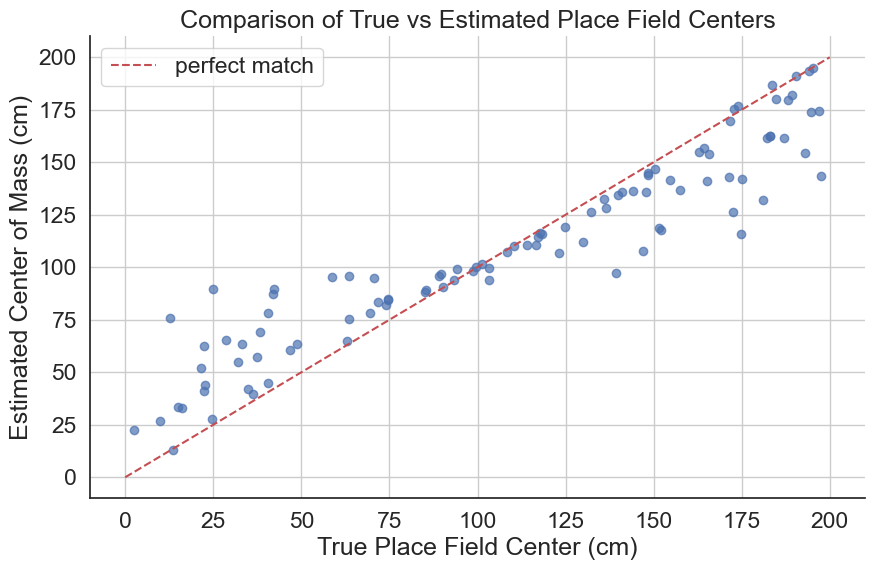

In [14]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

# Compute the estimated place field center as the center of mass of spike positions
spike_positions = [np.interp(s, t, x) for s in spikes]
empirical_centers = np.array([
    np.mean(s_pos) if len(s_pos) > 0 else np.nan 
    for s_pos in spike_positions
])

# Compare to the true place field centers from the simulation
plt.figure(figsize=(10, 6))
plt.scatter(pf_centers, empirical_centers, alpha=0.7)
plt.plot([0, 200], [0, 200], 'r--', label='perfect match')  # diagonal reference
plt.xlabel('True Place Field Center (cm)')
plt.ylabel('Estimated Center of Mass (cm)')
plt.title('Comparison of True vs Estimated Place Field Centers')
plt.legend()
plt.grid(True)
plt.show()


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.